# Centroid Measurement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from astropy.io import fits
%matplotlib widget

The following script uploads the first science corrected frame

In [2]:
# Carico la lista dei file science
science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
# Come per l'analisi fatta nella lezione precedente, carico solo i primi 30 frames.
science_test_list = science_list[:30]
# In questa variabile immagazzino il nome del primo corrected science frame.
science_frame_name = './group10_WASP-135_20190803/correct/' + science_test_list[0][:-5] + '_corr.p'
# Carico il file corrispondente a questo nome
science_corrected = pickle.load(open(science_frame_name, 'rb'))

### Identification of the target and reference stars

We now open and display a scientific frame and we identify the target star (the one with the transiting planet) and the reference stars (used to do differential photometry). By changing the $\texttt{vmin}$ and $\texttt{vmax}$ we can highlight fainter stars.

vmin:  1067.9   vmax: 110239.3


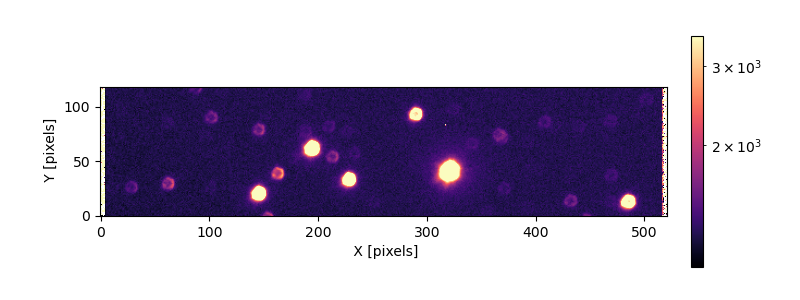

In [3]:
import matplotlib.colors as colors

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}   vmax: {1:.1f}'.format(vmin, vmax))

#Abbassiamo il vmax altrimenti non si vede molto
vmax=3500

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.show()


From this frame we can get an approximate location of the star (in pixels). In this case we got:

- x_target = 228
- y_target = 33

- x_reference_01 = 146
- y_reference_01 = 21

- x_reference_02 = 194
- y_reference_02 = 62

- x_reference_03 = 290
- y_reference_03 = 93

- x_reference_04 = 322
- y_reference_04 = 40

We don't need to be extremely precise at this stage, we will refine the coordinates afterwards. In the next cell there is a function that creates a plot, we use a function since we will use this plot a lot and we need to be able to call it often.

In [4]:
def make_circle_around_star(x_pos, y_pos, label='', color='w'):
    """
    This function creates a circle around the selected target in the science frame.

    Parameters:
    - x_pos: x coordinate of the target.
    - y_pos: y coordinate of the target.

    It does not return a variable but it produces a plot instead.
    """
    from matplotlib.patches import Circle # Serve per disegnare cerchi su un grafico

    n, radii = 50, [9, 15] #Numero di punti con cui approssimare la circonferenze e due raggi
    theta = np.linspace(0, 2*np.pi, n, endpoint=True) # Genera n valori di theta tra 0 e 2pi.
    xs = np.outer(radii, np.cos(theta)) # crea coordinata x per ogni raggio e theta
    ys = np.outer(radii, np.sin(theta)) # stessa cosa per la coordinata y

    #Il cerchio che abbiamo è in realtà un anello dato da un cerchio interno e uno esterno e noi coloriamo
    #la parte fra i due cerchi.

    # in order to have a closed area, the circles should be traversed in opposite directions
    xs[1,:] = xs[1,::-1] # L'ordine dei punti è importante per il corretto riempimento dell'area
    ys[1,:] = ys[1,::-1] # Deve essere cambiato perché ax.fill() lavora al contrario rispetto a come li abbiamo definiti

    #ax.fill riempie l'area tra i due cerchi
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)


With this function we can draw as many circles as we want by simply adding one line of code. We run the following code many times until the position of the circles are centered on the stars.

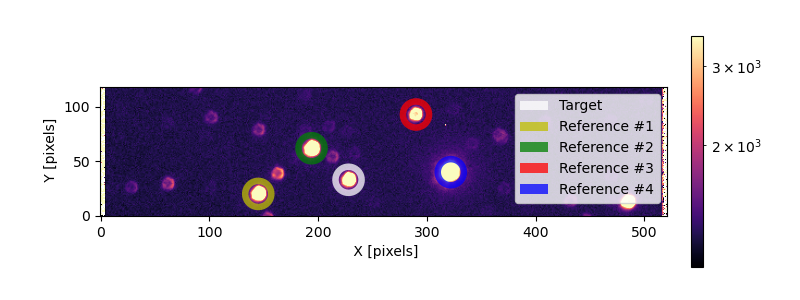

In [5]:
x_target = 228
y_target = 33

x_reference_01 = 145
y_reference_01 = 20

x_reference_02 = 194
y_reference_02 = 62

x_reference_03 = 290
y_reference_03 = 93

x_reference_04 = 322
y_reference_04 = 40

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star(x_target, y_target, label='Target', color='w')
make_circle_around_star(x_reference_01, y_reference_01, label='Reference #1', color='y')
make_circle_around_star(x_reference_02, y_reference_02, label='Reference #2', color='g')
make_circle_around_star(x_reference_03, y_reference_03, label='Reference #3', color='r')
make_circle_around_star(x_reference_04, y_reference_04, label='Reference #4', color='b')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.show()

### Photocenter determination of a star
The $\textbf{photocentre}$ of a star is the centre of light production defined as the centre of an Airy disk. In our analysis, we will use this term to identify the average position of the target on the sensor. The light distribution will have an irregular shape if the telescope has been defocused on purpose when collecting light curves for transit detection.
Here are the reasons why we defocus when collecting light curves
- **Reduction of atmospheric noise**: Defocusing spreads light over multiple pixels, reducing the effects of atmospheric turbulence and improving photometric stability.

- **Better signal-to-noise ratio (SNR)**: Prevents sensor saturation and reduces readout noise, increasing measurement accuracy.

- **More accurate differential photometry**: Smoother light profiles minimize systematic errors caused by pixel sensitivity variations.

- **Minimization of defective pixel effects**: Spreading light across multiple pixels reduces the impact of anomalous or non-uniform pixels.

- **Higher tolerance to guiding errors**: A defocused image makes small telescope tracking errors less critical.

In order to have a clearer idea of the possible radius from the star's centre at which the star flux is negligible we need a 3D plot. We start by employing the numpy.meshgrid function to build two 2D arrays X and Y. Each array has the same shape as our frames and contain che x and y coordinate of the corresponding pixel.

In [6]:
ylen, xlen = np.shape(science_corrected)
print('Shape of our science frame: {0:d} x {1:d}'.format(xlen, ylen))
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)
# print('Shape of our 2D arrays: {0} , {1}'.format(np.shape(X), np.shape(Y)))
# print(X, Y)

Shape of our science frame: 521 x 119


We want to plot the flux on the z axis but we don't want to be affected by the nasty values in the overscan region.

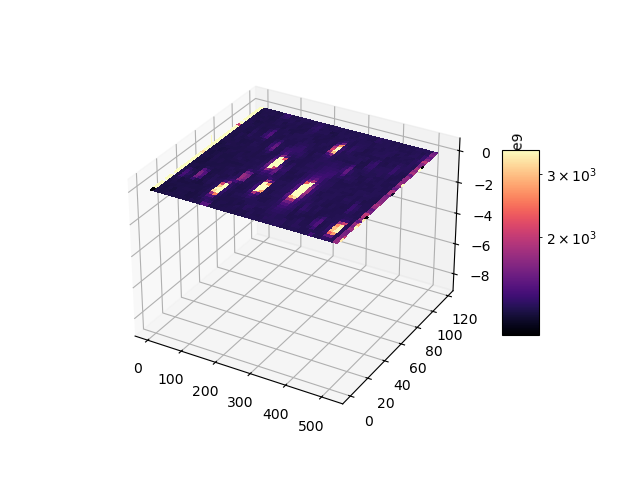

In [7]:
# subplot_kw={"projection": "3d"} dice a matplotlib di creare un sistema di coordinate 3D per ax
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot_surface disegna una superficie tridimensionale
surf = ax.plot_surface(X, Y, science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), linewidth=0, antialiased=False)
# antialising è una tecnica per smussare i bordi

# shrink = 0.5 riduce l'altezza della barra dei colori al 50% di quella predefinita
# aspect = 5 significa che sarà 5 volte più alta che larga.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Now we make a few improvements:
1. We centre the 3d plot around the estimated coordinates of our target;
2. We limit our plot within a radius of 15 pixels around the centre of the target;
3. We change the $\texttt{vmax}$ value to 20000 to display more details;
4. We make the colorbar smaller and thinner.

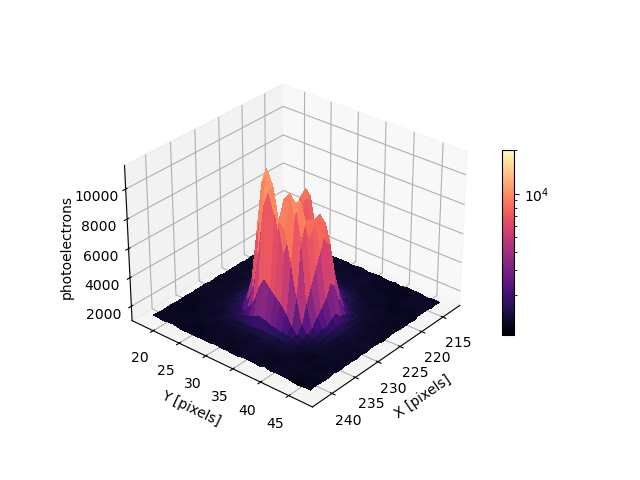

In [8]:
vmax = 20000
radius_plot = 15

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface
surf = ax.plot_surface(X[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                       Y[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                       science_corrected[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                       cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin, vmax),
                       linewidth=0, antialiased=False)

# Questi parametri controllano la rotazione orizzontale e verticale della visualizzazione

ax.azim = 40 #value in degree
ax.elev = 30

ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')

# Fix the orientation fo the Z label
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('photoelectrons', rotation=90)

## Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=15, ticks=[10, 100, 1000, 10000, 100000])

plt.show()



### Advantages of using $\texttt{numpy.meshgrid}$
Computing two 2D arrays containing one of the two coordinates of each pixel may appear as an unnecessary complication. If we want to compute the distance of each pixel from the photocentre we need this information.
We will now compare two algorithms, one with meshgrid and one without it and measure how much time it takes.


In [9]:
# First Algortihm - Iterate over each pixel
import time

t0 = time.time()

rr_method01 = np.zeros_like(science_corrected)
for y_i in range(0, np.shape(science_corrected)[0]):
    for x_i in range(0, np.shape(science_corrected)[1]):
        rr_method01[y_i, x_i] = np.sqrt((x_i - x_target)**2 + (y_i - y_target)**2)

t1 = time.time()

total_method01 = t1- t0
print('Time required by the first method: {0:f} seconds'.format(total_method01))



Time required by the first method: 0.182240 seconds


In [10]:
# Second Algortihm - Meshgrid

t0 = time.time()

X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

t1 = time.time()

rr_method02 = np.sqrt((X - x_target)**2 + (Y - y_target)**2)

t2 = time.time()

prepare_method02 = t1 - t0
total_method02 = t2 - t1

print('Time required to set up the second algorithm: {0:f} seconds'.format(prepare_method02))
print('Time required by second algorithm:            {0:f} seconds'.format(total_method02))

Time required to set up the second algorithm: 0.000000 seconds
Time required by second algorithm:            0.000000 seconds


### Centroid Algorithm
We need to determine the centre of this distribution. We need:
1. A fast algorithm (needs to run hundreds of times).
2. A robust algorithm that reaches convergence regardless of initizl conditions and perturbations.
3. A simple algorithm that can work without any prior knowledge of the PSF of the instrument as the defocusing change night by night.

We use a **weighted centroid** method, weighing the coordinates of each pixel accordin to the flux and compute the average within a distance from the centre.
The *inner radius* must be large enough to include all the flux coming from the star, and some sky background as well.

In [11]:
# Centroid Algortihm

# Initial coordinates of the target and radius
# x_target, y_target
inner_radius = 14 #[Pixels]

# Compute the meshgrid, we do this again since this algorithm will be exported to the class later
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

# Compute the distance between each pixel and the target
target_distance = np.sqrt((X-x_target)**2 + (Y-y_target)**2) #It's a matrix

# Selection of the pixels within the selected radius
'''In this case we have a 2D boolean array, if target_distance > inner_radius we find False, otherwise True'''
annulus_selection = (target_distance < inner_radius)

# Weighted sum of coordinates: each point is worth its flux (if inside the radius).
weighted_X = np.sum(science_corrected[annulus_selection]*X[annulus_selection])
weighted_Y = np.sum(science_corrected[annulus_selection]*Y[annulus_selection])

# Sum of the weights


(119, 521)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
